In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1bD3P4u0Va7kxo4rERbE638dQg0hd3Bvm/view?usp=sharing'

In [4]:
id = '1bD3P4u0Va7kxo4rERbE638dQg0hd3Bvm'

In [5]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('creditcard.csv')  
df = pd.read_csv('creditcard.csv')
# Dataset is now stored in a Pandas Dataframe

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape

(284807, 31)

In [8]:
tot =  df.shape[0]
fraud = df[df['Class'] == 1].shape[0]
print('Number of fraud transaction      = ', fraud)
print('Percentage of fraud transaction  = ',round((fraud / tot)* 100, 4))

Number of fraud transaction      =  492
Percentage of fraud transaction  =  0.1727


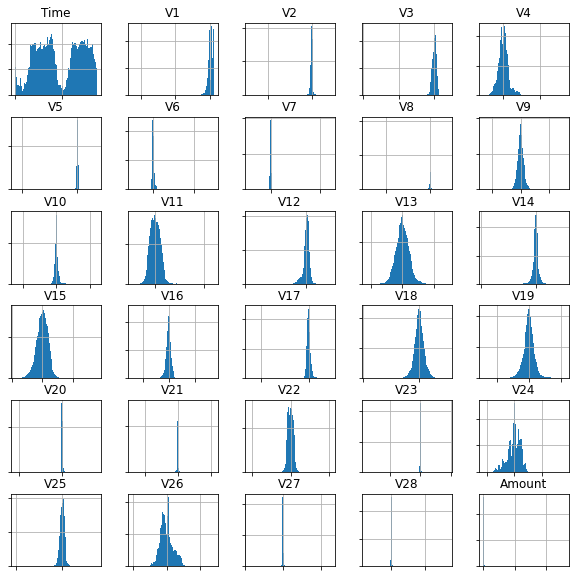

In [9]:
temp = df.drop('Class', axis=1)
ax = temp.hist(bins = 100, figsize = (10, 10))
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
plt.show()

most of them are gaussian, may be the data has been standardized 

In [10]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

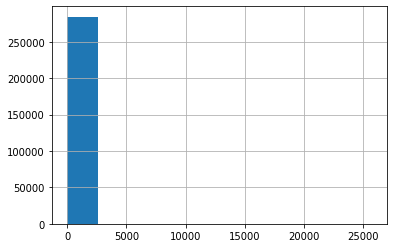

Amounts greater than 1500 =  0.468 %


In [11]:
ax = temp['Amount'].hist(bins=10)
plt.show()
perc = temp[temp['Amount'] > 1500].shape[0] / temp.shape[0] * 100
print('Amounts greater than 1500 = ',  round(perc, 3),'%')

We can see that there are very few outliers in Amounts feature

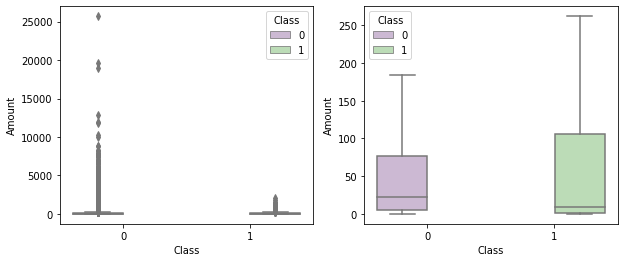

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(10, 4))
s = sns.boxplot(ax = ax1, x = "Class", y = "Amount", hue = "Class", data = df, palette = "PRGn",showfliers = True)
s = sns.boxplot(ax = ax2, x = "Class", y = "Amount", hue = "Class", data = df, palette = "PRGn",showfliers = False)
plt.show();

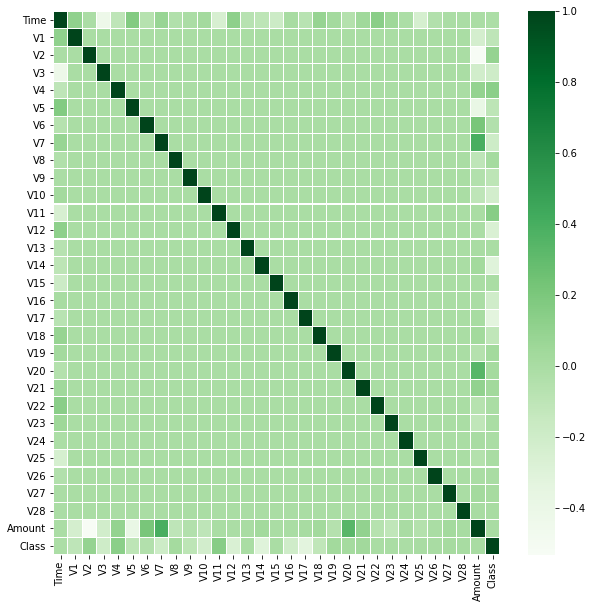

In [13]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = .1, cmap="Greens")
plt.show()

There is no significant correlation between most of the features

In [32]:
import random 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb

from sklearn import svm, datasets
 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  

## Oversampling and XGB

In [15]:
target = 'Class'
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
            'V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
            'V19','V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 
            'V28','Amount']

In [16]:
X_train = df[features]
y_train = df[target]

In [17]:
from imblearn.over_sampling import SMOTE
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)
smote_value_counts = np.count_nonzero(y_train_smote==1)
print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts * 100 / len(y_train_smote)))


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fraudulent transactions are 50.00% of the test set.


In [33]:
def xgb_train(X, y, search_verbose=1):
     
    params = {
        "gamma":[0.5, 1, 1.5],
        "max_depth":[3, 4, 5],
        "learning_rate": [0.1, 0.01, 0.001]
    }
     
     
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
  
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
     
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)
  
    grid_search.fit(X, y)
  
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Best Hyperparameters: ", grid_search.best_params_) 
    print("Highest AUC: %.2f" % grid_search.best_score_)
     
    return grid_search.best_params_


In [34]:
from xgboost import XGBClassifier
rows = random.sample(np.arange(0,len(X_train_smote)).tolist(), 5000)
model_params = xgb_train(X_train_smote[rows,], y_train_smote[rows,])

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.3min finished


Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.5, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)
Best Hyperparameters:  {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4}
Highest AUC: 1.00


In [36]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.5, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [44]:
train_df, test_df  = train_test_split(df, test_size = .2, random_state = 2021, shuffle = True )

train_df, valid_df = train_test_split(train_df, test_size = .2, random_state = 9, shuffle = True )


In [45]:
model_preds = model.predict(test_df[features].values)

In [46]:
roc_auc_score(test_df[target].values, model_preds)

0.9884973508817674

# Other models


## Random Forest Classifier

In [47]:
RFclf = RandomForestClassifier(n_jobs = 4, 
                             random_state = 45,
                             criterion = 'gini',
                             n_estimators = 100,
                             verbose = False)

In [48]:
RFclf.fit(train_df[features], train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=45, verbose=False,
                       warm_start=False)

In [49]:
RFpreds = RFclf.predict(valid_df[features])

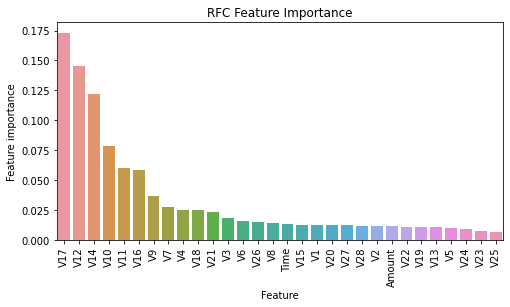

In [50]:
# Feature Importance

def plot_feat_imp(clf, model_name, ):
    tmp = pd.DataFrame({'Feature': features, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending = False)
    plt.figure(figsize = (8,4))
    plt.title(model_name + ' Feature Importance', fontsize = 12)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data=tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show()   
    
plot_feat_imp(RFclf, 'RFC')

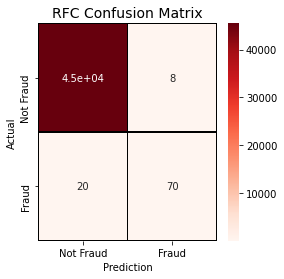

In [51]:
def plot_conf_mat(preds, model_name) :
    cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames = ['Prediction'])
    fig, (ax1) = plt.subplots(ncols = 1, figsize=(4, 4))
    sns.heatmap(cm, 
                xticklabels = ['Not Fraud', 'Fraud'],
                yticklabels = ['Not Fraud', 'Fraud'],
                annot = True,ax = ax1,
                linewidths = .2, linecolor = "Black", cmap = "Reds")
    plt.title(model_name + ' Confusion Matrix', fontsize=14)
    plt.show()
plot_conf_mat(RFpreds, 'RFC')

In [52]:
roc_auc_score(valid_df[target].values, RFpreds)

0.8888009362074314

## AdaBoost Classifier

In [53]:
ABclf = AdaBoostClassifier(random_state = 1, algorithm='SAMME.R', learning_rate=0.8, n_estimators = 100)

In [54]:
ABclf.fit(train_df[features], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=1)

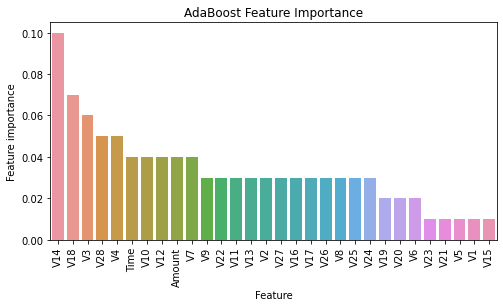

In [55]:
plot_feat_imp(ABclf, 'AdaBoost')

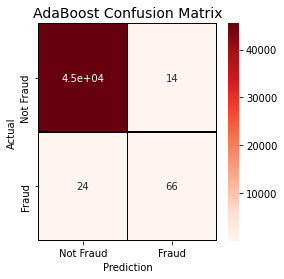

In [56]:
ABpreds = ABclf.predict(valid_df[features])
plot_conf_mat(ABpreds, 'AdaBoost')

In [57]:
roc_auc_score(valid_df[target].values, ABpreds)

0.8665127494741163

In [58]:
ABpreds = ABclf.predict(test_df[features])

In [59]:
roc_auc_score(test_df[target].values, ABpreds)

0.8639985267593471

## XGBoost Classifier

In [60]:
dtrain = xgb.DMatrix(train_df[features], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[features], valid_df[target].values)
dtest = xgb.DMatrix(test_df[features], test_df[target].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = 1

In [61]:
model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds = 50, 
                maximize = True, 
                verbose_eval = 50)

[0]	train-auc:0.871118	valid-auc:0.849777
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.919432	valid-auc:0.927437
Stopping. Best iteration:
[34]	train-auc:0.917869	valid-auc:0.927521



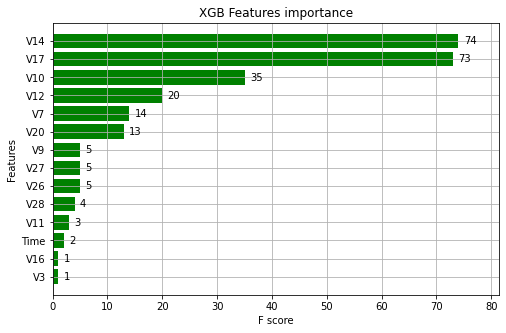

In [62]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="XGB Features importance", ax=ax, color="green") 
plt.show()

In [63]:
XGBpreds = model.predict(dtest)

In [64]:
roc_auc_score(test_df[target].values, XGBpreds)

0.9266867265081039